In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipas
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import time
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import dask
from mpl_toolkits.mplot3d import Axes3D
from shapely.ops import nearest_points
from pyquaternion import Quaternion
import copy as cp
from scipy import spatial 
from shapely.geometry import Point
from shapely.ops import nearest_points
import pandas as pd
from dask import dataframe as dd
import pickle
import scipy.stats as st
import datetime

In [59]:
cluster = SLURMCluster(
queue='kratos',
walltime='04-23:00:00',
cores=1,
memory='20000MiB', #1 GiB = 1,024 MiB
processes=1)

cluster.scale(28)
client = Client(cluster)
print(client)

/network/rit/lab/sulialab/share/bin/miniconda3/envs/IPAS/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37195 instead
  http_address["port"], self.http_server.port


<Client: 'tcp://169.226.65.140:35577' processes=0 threads=0, memory=0 B>


In [60]:
client

Client Scheduler: tcp://169.226.65.140:35577 Dashboard: http://169.226.65.140:37195/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
def main():
    output = np.empty((len(phioarr),len(reqarr)),dtype=object)
    for phi in range(len(phioarr)):
        for r in range(len(reqarr)):
            #output[phi,r] = dask.delayed(ipas.collect_clusters)(phioarr[phi], reqarr[r], nclusters, ncrystals,rand_orient)
            ipas.collect_clusters(phioarr[phi], reqarr[r], nclusters, ncrystals,rand_orient)
    #delayeds = client.compute(delayeds)
    #output = client.gather(delayeds)
    
    return output

In [4]:
def compute():
    agg_as = np.empty((len(phioarr),len(reqarr), nclusters))
    agg_bs = np.empty((len(phioarr),len(reqarr), nclusters))
    agg_cs = np.empty((len(phioarr),len(reqarr), nclusters))
    #phi2Ds = np.empty((len(phioarr),len(reqarr), nclusters))
    #cplxs = np.empty((len(phioarr),len(reqarr), nclusters))
    #dds = np.empty((len(phioarr),len(reqarr), nclusters))
    #major_ax_zs = np.empty((len(phioarr),len(reqarr), nclusters))
    #depths = np.empty((len(phioarr),len(reqarr), nclusters))
    
    gather = client.compute([*output.tolist()])  #only parallelizing agg r bins
    gather = client.gather(gather)

    gather = np.array(gather)
    print(np.shape(gather))
    agg_as = gather[:,:,0,:]
    agg_bs = gather[:,:,1,:]
    agg_cs = gather[:,:,2,:]
    #phi2Ds = gather[:,:,3,:]
    #cplxs = gather[:,:,4,:] 
    #dds = gather[:,:,5,:]
    #major_ax_zs = gather[:,:,6,:]
    #depths = gather[:,:,7,:]
    print('DONE!')
    return agg_as, agg_bs, agg_cs #, phi2Ds, cplxs, dds, major_ax_zs, depths

83.3866870048148 46.41588833612778 0.7965117117000392
agg phi 0.01386204560532799 0.01 0.0038620456053279906


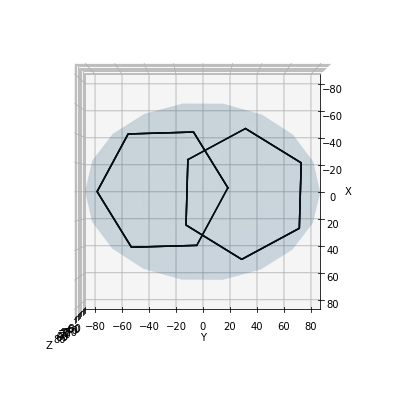

77.73657715708164 46.41588833612778 0.6747837851155684
agg phi 0.015074372559409488 0.01 0.005074372559409488


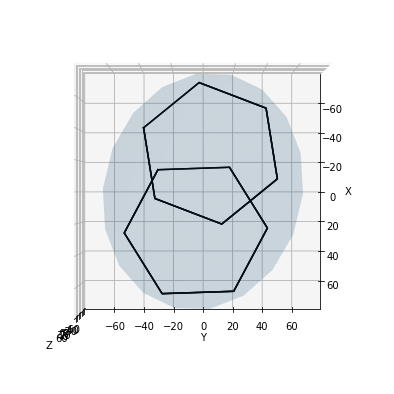

66.4486782282273 46.41588833612778 0.4315933748165928
agg phi 0.019663564086372556 0.01 0.009663564086372556


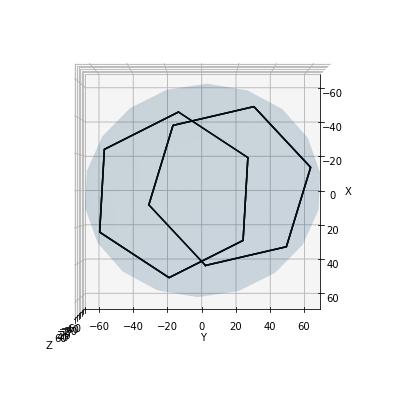

95.47598679931777 46.41588833612778 1.0569677802547643
agg phi 0.011199898486150047 0.01 0.001199898486150047


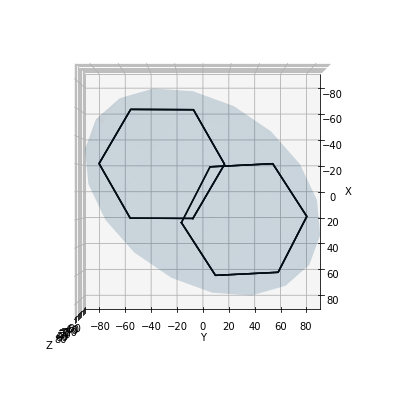

57.99204161142173 46.41588833612778 0.2494006619341951
agg phi 0.026185218790471428 0.01 0.016185218790471426


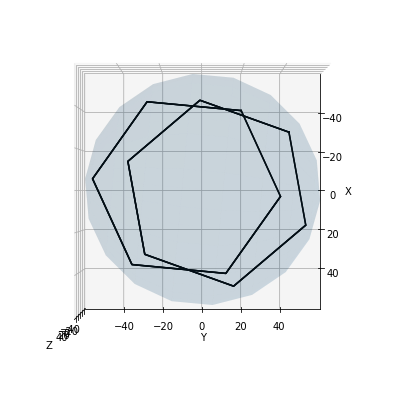

57.8794102985138 46.41588833612778 0.24697409385706817
agg phi 0.02642349622321768 0.01 0.016423496223217683


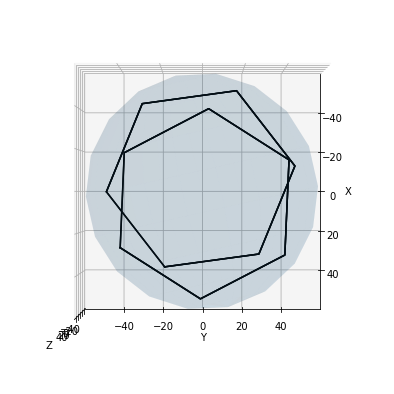

65.09787165452414 46.41588833612778 0.402491129397501
agg phi 0.020466147096754456 0.01 0.010466147096754455


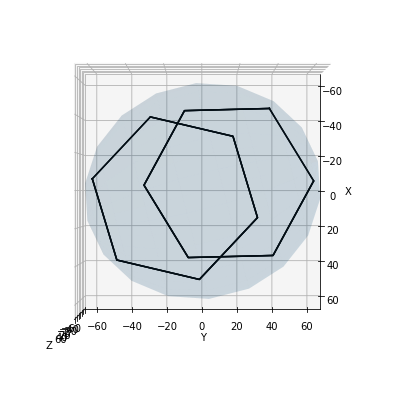

62.11036670699223 46.41588833612778 0.3381272864414547
agg phi 0.02236058629093076 0.01 0.01236058629093076


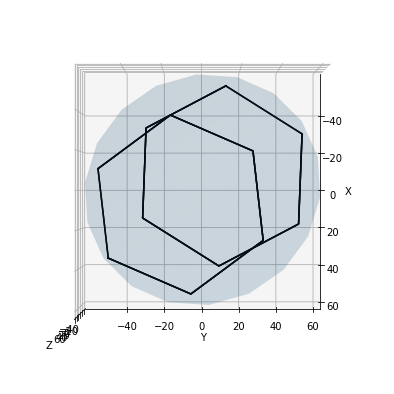

87.86735414921286 46.41588833612778 0.893044759003812
agg phi 0.013117279553386381 0.01 0.0031172795533863807


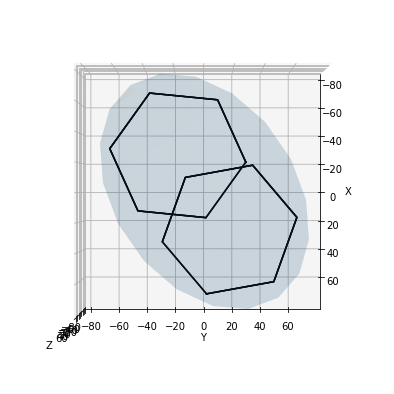

58.045839942348856 46.41588833612778 0.2505597118383472
agg phi 0.026172209647890615 0.01 0.016172209647890616


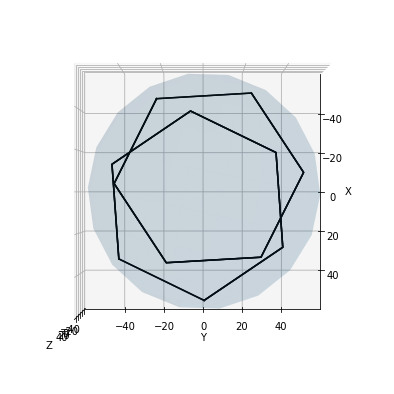

79.53512288495646 46.41588833612778 0.71353227819299
agg phi 0.014723831389970693 0.01 0.004723831389970692


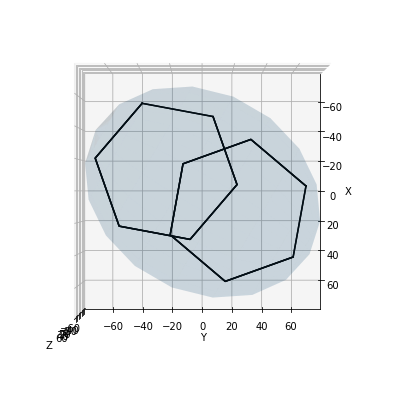

102.11390992585105 46.41588833612778 1.1999774987904464
agg phi 0.010612848671193015 0.01 0.0006128486711930153


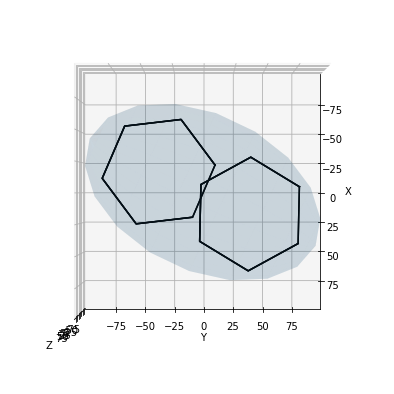

64.19160279256904 46.41588833612778 0.3829661586505832
agg phi 0.020909558161712256 0.01 0.010909558161712256


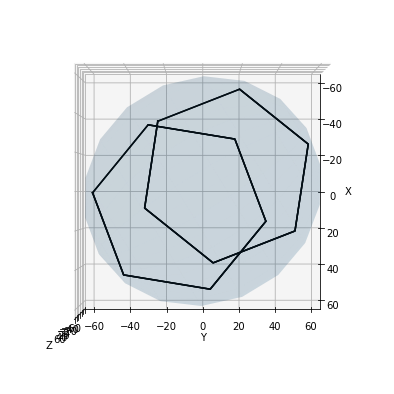

59.298632462367635 46.41588833612778 0.27755030848375645
agg phi 0.025063182981739353 0.01 0.015063182981739353


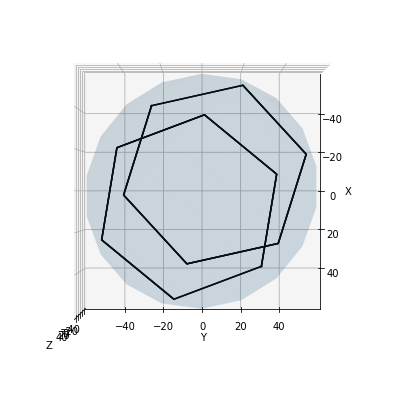

82.82030028455584 46.41588833612778 0.7843092797190464
agg phi 0.013982830455164057 0.01 0.003982830455164057


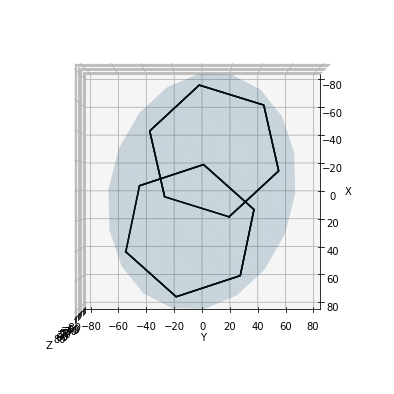

97.20486609912095 46.41588833612778 1.0942153556385046
agg phi 0.011296977913656872 0.01 0.0012969779136568719


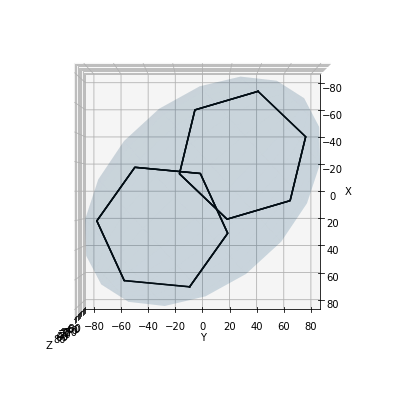

70.53683537183737 46.41588833612778 0.5196700505015449
agg phi 0.01714271925736166 0.01 0.00714271925736166


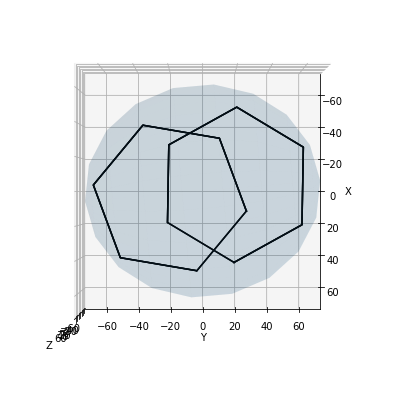

72.98918272936922 46.41588833612778 0.5725042726922913
agg phi 0.017016458119828964 0.01 0.007016458119828964


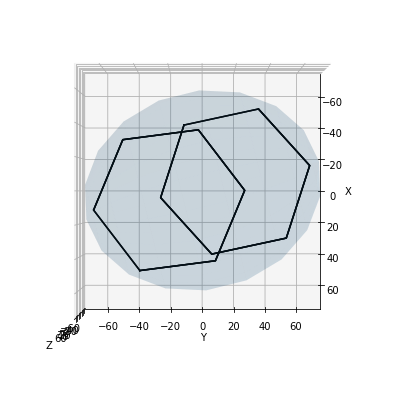

58.44431634586797 46.41588833612778 0.25914462570735436
agg phi 0.026022719913051922 0.01 0.016022719913051924


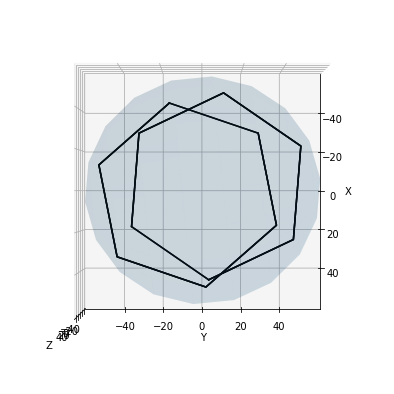

59.040054743254224 46.41588833612778 0.2719794204024839
agg phi 0.025423114487606747 0.01 0.015423114487606747


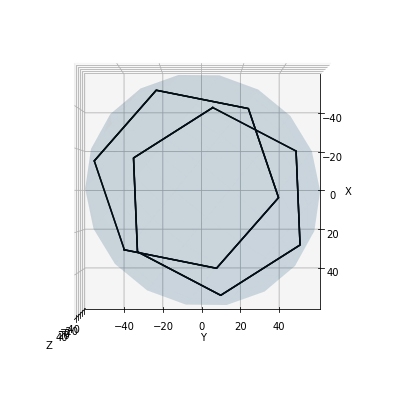

82.83567583451915 46.41588833612778 0.7846405359012391
agg phi 0.013734079972237903 0.01 0.0037340799722379026


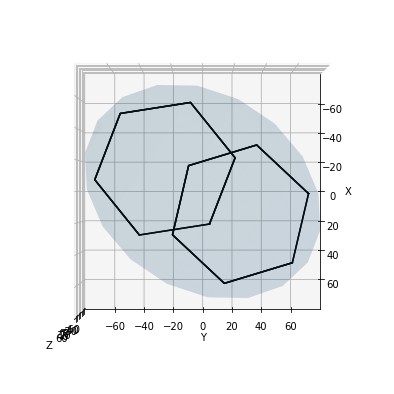

92.67502595116545 46.41588833612778 0.9966229080879596
agg phi 0.011863497330606097 0.01 0.0018634973306060967


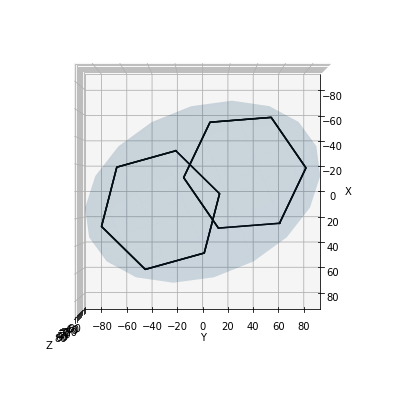

94.02842921524069 46.41588833612778 1.0257810975052204
agg phi 0.011687350577478238 0.01 0.0016873505774782378


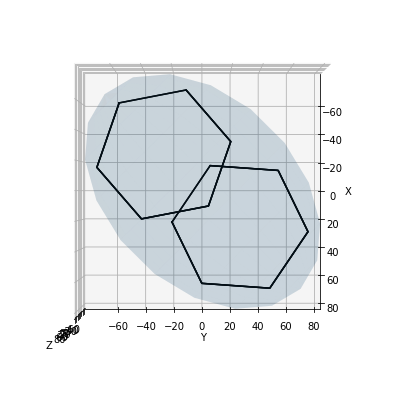

107.20900862688558 46.41588833612778 1.3097480726968982
agg phi 0.010171186235301402 0.01 0.00017118623530140188


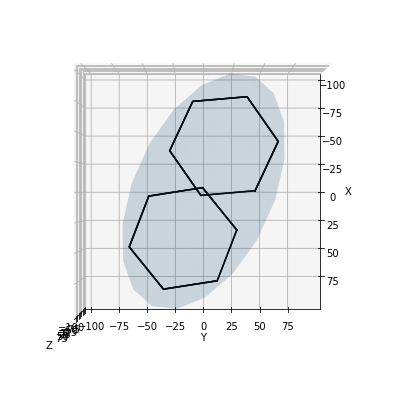

57.39979105028743 46.41588833612778 0.23664101039320926
agg phi 0.02690755392208152 0.01 0.01690755392208152


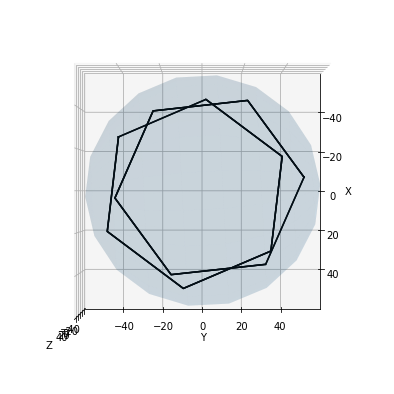

59.12133863374565 46.41588833612778 0.2737306287366387
agg phi 0.02533668920626641 0.01 0.015336689206266409


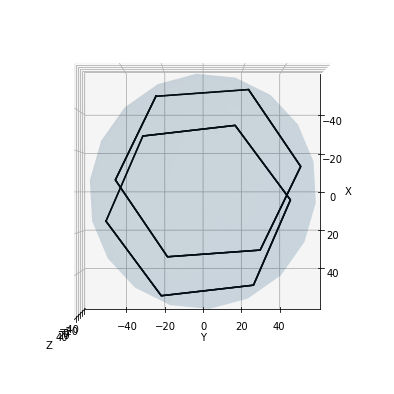

KeyboardInterrupt: 

In [40]:
if __name__ == '__main__':
    phioarr=np.logspace(-1.5, 2, num=20, dtype=None)#just columns (0,2); plates (-2,0)
    phioarr = [.01]
    #reqarr = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]
    reqarr = [10] 
    nclusters = 300         #changes how many aggregates per aspect ratio to consider
    ncrystals = 2
    rand_orient = False      #randomly orient the seed crystal and new crystal: uses first random orientation
    
    output = main()
    agg_as, agg_bs, agg_cs, = compute()

In [63]:
results = {'agg_as': agg_as, 'agg_bs':agg_bs, 'agg_cs':agg_cs}
filename = '../instance_files/instance_iceice_flat_r10_phi20_run5'
filehandler = open(filename, 'wb')
pickle.dump(results, filehandler)
filehandler.close()
print('finished!')

finished!


In [66]:
#np.random.seed()
print(np.random.rand(10))
print(np.random.rand(10))
print(np.random.rand(10))

[0.09939954 0.69026344 0.92866276 0.42616034 0.68154838 0.44398099
 0.9071735  0.96912605 0.27922703 0.94888055]
[0.44001745 0.59387576 0.43243241 0.03593723 0.47821425 0.33172738
 0.38821068 0.15671617 0.2979128  0.02278904]
[0.19096494 0.3088947  0.09705942 0.36845447 0.68909024 0.79557715
 0.57359809 0.16039724 0.94455915 0.87181101]


In [69]:
import random

In [72]:
np.random.seed(0)
print(np.random.rand(10))
np.random.seed(0)
print(np.random.rand(10))
print(np.random.rand(10))

[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548  0.64589411
 0.43758721 0.891773   0.96366276 0.38344152]
[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548  0.64589411
 0.43758721 0.891773   0.96366276 0.38344152]
[0.79172504 0.52889492 0.56804456 0.92559664 0.07103606 0.0871293
 0.0202184  0.83261985 0.77815675 0.87001215]
